# Obliczanie pierwiastków wielomianów w postaci

$f(x) = ax^3 + bx^2 + cx + d,\quad a,b,c,d \in R$


Zaczniemy od dodania potrzebnych biblotek pozwalających nam zdefiniować wielomiany w języku Julia oraz
rysować potrzebne wykresy

In [2485]:
using Polynomials
using Plots

setprecision(128)

128

Zdefinijumy sobie przykładowy wielomian: $x^3 + x^2 + x + 1$ i narysujmy jego wykres.

In [2486]:
f = fromroots([0 - 1im,0 + 1im,-1])

Polynomial(1 + x + x^2 + x^3)

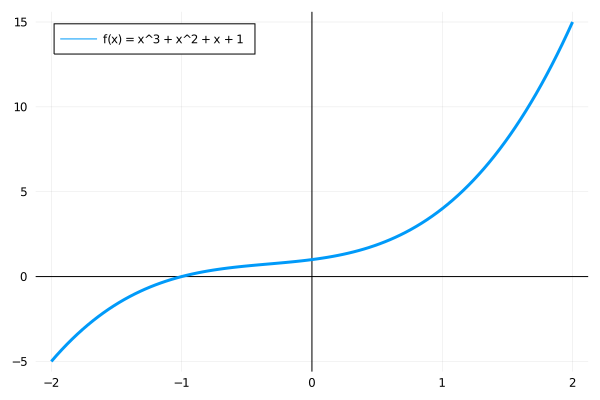

In [2487]:
default(framestyle = :zerolines)
plot(f, -2, 2, label = "f(x) = x^3 + x^2 + x + 1", linewidth = 3, legend = :topleft)

# Obliczanie wartości funkcji i pochodnych

Potrzebujemy sprawnego i szybkiego algorytmu do obliczania wartości naszych wielomianów oraz ich pochodnych pierwszego stopnia. Do tego użyjemy rozszerzonego schematu Hornera danego algorytmem:

In [2488]:
# Funkcja dla danej funkcji f i argumentu x zwróci parę (f(x0), f'(x0)).

function Horner(polynomial, x)
    n = length(polynomial) - 1
    
    f  = polynomial[n]
    ∂f = 0
    
    for i = n - 1:-1:0
        ∂f = f + x * ∂f
        f  = polynomial[i] + x * f
    end
    
    return f, ∂f
end

Horner (generic function with 1 method)

Sprawdźdmy poprawność działania algorytmu dla kilku przykładowych punktów

In [2489]:
using Printf

println("Dla x = 0: ", Horner(f, 0))
println("Dla x = 2: ", Horner(f, 2))
println("Dla x = 4: ", Horner(f, 4))

Dla x = 0: (1, 1)
Dla x = 2: (15, 17)
Dla x = 4: (85, 57)


# Dzielenie wielomianów 3 stopnia przez wielomian (x - x0)

Jest to zwykły algorytm Hornera, do dzielenia wielominaów.

In [2490]:
function divide(f, x0) 
    b = zeros(3)
    b[3] = f[3]
    
    for i = 2:-1:1
        b[i] = f[i] + x0 * b[i + 1]
    end
 
    return Polynomial(b)
end

divide (generic function with 1 method)

# Metoda wyznczania pierwiastków wielomianów kwadratowych

Przed implementacją innych metod, potrzebuję mieć algorytm numerycznie poprawny, który znajdzie pierwiastki funkcji kwadratowej. Mogę to zrobić wyznaczając wyróżnik funkcji i używając istniejących wzorów Viete'a uważając, aby nie utracić cyfr znaczących.

In [2491]:
# Funkcja, dla danej funkcji f zwróci jej pierwiastki zespolone

function solveQuadratic(f)
    a = f[2]
    b = f[1]
    c = f[0]
    
    x1 = 0
    x2 = 0
    
    Δ = b * b - 4 * a * c
    
    if (Δ > 0)
        
        if (b > 0)
            x1 = (-b - sqrt(Δ)) / (2 * a)
        else
            x1 = (-b + sqrt(Δ)) / (2 * a)
        end
        x2 = c / (a * x1)
            
    elseif (Δ == 0)        
        x1 = -b / (2 * a)        
        x2 = -b / (2 * a)
    else
        
        if (b > 0)
            x1 = (-b - sqrt(-Δ)*im) / (2 * a)
        else
            x1 = (-b + sqrt(-Δ)*im) / (2 * a)
        end
        x2 = c / (a * x1)
    end
    
    return [x1, x2]
end

solveQuadratic (generic function with 1 method)

In [2492]:
solveQuadratic(Polynomial([-1,0,1]))

2-element Array{Float64,1}:
  1.0
 -1.0

In [2493]:
solveQuadratic(Polynomial([1,0,1]))

2-element Array{Complex{Float64},1}:
 0.0 + 1.0im
 0.0 - 1.0im

In [2494]:
solveQuadratic(Polynomial([5,2,3]))

2-element Array{Complex{Float64},1}:
 -0.3333333333333333 - 1.247219128924647im
 -0.3333333333333333 + 1.2472191289246473im

In [2495]:
roots(Polynomial([5,2,3]))

2-element Array{Complex{Float64},1}:
 -0.33333333333333337 - 1.2472191289246473im
 -0.33333333333333337 + 1.2472191289246473im

# Metoda Newtona

Poniżej znajduje się zaimplementowany algorytm metody Newtona

In [2496]:
# Funkcja dla danej funkcji f, danego punktu startowego x0 zwróci pierwiastek z dokładnością do ε.
# Oczywiście tylko jeśli x0 będzie dostatecznie tego pierwiastka.
# Ponieważ metoda może być rozbieżna ograniczę liczbę iteracji do M.

function Newton(f, x0, ε, M, print = false)
    v = Horner(f, x0)
    
    if (abs(v[1]) < ε)
        return x0
    end
    
    for i = 1:M
        x1 = x0 - v[1] / v[2]
        v = Horner(f, x1)
        
        rε = abs((x1 - x0) / x1)
        
        if print
            @printf("Iteracja: %d, x_i = %f, błąd bezwględny = %f\n", i, x1, rε)
        end
            
        if (abs(v[1]) < ε)
            x0, x2 = solveQuadratic(divide(f, x1))
            
            return [x0, x1, x2]
        end
        
        x0 = x1
    end
    
    x1, x2 = solveQuadratic(divide(f, x0))
            
    return [x0, x1, x2]
end

Newton (generic function with 3 methods)

Przetestujmy działanie algorytmu dla kilku punktów startowych dla naszej funkcji f.

In [2497]:
Newton(f, 5, 1.0e-10, 20)

3-element Array{Complex{Float64},1}:
 8.881784197001252e-16 + 1.0000000000000009im
   -1.0000000000000018 + 0.0im
 8.881784197001252e-16 - 1.0000000000000009im

In [2498]:
Newton(f, -6, 1.0e-10, 20)

3-element Array{Complex{Float64},1}:
 4.440892098500626e-16 + 1.0000000000000004im
   -1.0000000000000009 + 0.0im
 4.440892098500626e-16 - 1.0000000000000004im

In [2499]:
Newton(f, 100, 1.0e-10, 20, true)

Iteracja: 1, x_i = 66.554055, błąd bezwględny = 0.502538
Iteracja: 2, x_i = 44.255989, błąd bezwględny = 0.503843
Iteracja: 3, x_i = 29.389435, błąd bezwględny = 0.505847
Iteracja: 4, x_i = 19.476583, błąd bezwględny = 0.508963
Iteracja: 5, x_i = 12.865175, błąd bezwględny = 0.513900
Iteracja: 6, x_i = 8.453046, błąd bezwględny = 0.521957
Iteracja: 7, x_i = 5.504251, błąd bezwględny = 0.535730
Iteracja: 8, x_i = 3.525977, błąd bezwględny = 0.561057
Iteracja: 9, x_i = 2.185383, błąd bezwględny = 0.613436
Iteracja: 10, x_i = 1.251379, błąd bezwględny = 0.746380
Iteracja: 11, x_i = 0.546928, błąd bezwględny = 1.288014
Iteracja: 12, x_i = -0.124919, błąd bezwględny = 5.378247
Iteracja: 13, x_i = -1.240055, błąd bezwględny = 0.899263
Iteracja: 14, x_i = -1.045616, błąd bezwględny = 0.185956
Iteracja: 15, x_i = -1.001988, błąd bezwględny = 0.043541
Iteracja: 16, x_i = -1.000004, błąd bezwględny = 0.001984
Iteracja: 17, x_i = -1.000000, błąd bezwględny = 0.000004


3-element Array{Complex{Float64},1}:
 7.781220112690335e-12 + 1.000000000007781im
   -1.0000000000155624 + 0.0im
 7.781220112690338e-12 - 1.0000000000077813im

# Metoda bisekcji

Poniżej znajduje się zaimplementowany algorytm metody Bisekcji, wyznaczający dwa pozostałe pierwiastki przy pomocy wzorów Viete'a.

In [2500]:
# Funkcja, dla danej funkcji f, dwóch punktów startowych x0 <= x1 zwróci pierwiastek x0 z dokładnością do ε.
# Oraz pierwiastki x1, x2 policzone ze wzorów Viete'a
# Ponieważ metoda może być rozbieżna ograniczę liczbę iteracji do M.

function Bisection(f, x0, x1, ε, M, print = false)
    a = Horner(f, x0)[1]
    b = Horner(f, x1)[1]
    
    if (sign(a) == sign(b))
        x1, x2 = solveQuadratic(divide(f, x0))
                
        return [x0, x1, x2]
    end
    
    for i = 1:M
        x2 = ((x0 + x1) / 2)
        
        v = Horner(f, x2)[1]
        
        if print
            @printf("Iteracja: %d, a = %f, b = %f, c = %f, f(c) = %f\n", i, x0, x1, x2, v)
        end
        
        if (abs(v) < ε)
            x0, x1 = solveQuadratic(divide(f, x2))
            
            return [x0, x1, x2]
        end
        
        if (sign(a) != sign(v))
            x1 = x2
        else
            x0 = x2
        end
    end
        
    x1, x2 = solveQuadratic(divide(f, x0))
                
    return [x0, x1, x2]
end

Bisection (generic function with 2 methods)

In [2501]:
Bisection(f, -5, 5, 1.0e-10, 20)

3-element Array{Complex{Float64},1}:
 -1.0000038146972656 + 0.0im
  1.9073486328125e-6 + 1.0000019073522708im
  1.9073486328125e-6 - 1.0000019073522708im

In [2502]:
Bisection(f, -50, 50, 1.0e-10, 20)

3-element Array{Complex{Float64},1}:
   -1.0000228881835938 + 0.0im
    1.1444091796875e-5 + 1.0000114442227626im
 1.1444091796875002e-5 - 1.0000114442227628im

In [2503]:
Bisection(f, -3, 16, 1.0e-10, 20, true)

Iteracja: 1, a = -3.000000, b = 16.000000, c = 6.500000, f(c) = 324.375000
Iteracja: 2, a = -3.000000, b = 6.500000, c = 1.750000, f(c) = 11.171875
Iteracja: 3, a = -3.000000, b = 1.750000, c = -0.625000, f(c) = 0.521484
Iteracja: 4, a = -3.000000, b = -0.625000, c = -1.812500, f(c) = -3.481689
Iteracja: 5, a = -1.812500, b = -0.625000, c = -1.218750, f(c) = -0.543671
Iteracja: 6, a = -1.218750, b = -0.625000, c = -0.921875, f(c) = 0.144520
Iteracja: 7, a = -1.218750, b = -0.921875, c = -1.070313, f(c) = -0.150860
Iteracja: 8, a = -1.070313, b = -0.921875, c = -0.996094, f(c) = 0.007782
Iteracja: 9, a = -1.070313, b = -0.996094, c = -1.033203, f(c) = -0.068648
Iteracja: 10, a = -1.033203, b = -0.996094, c = -1.014648, f(c) = -0.029729
Iteracja: 11, a = -1.014648, b = -0.996094, c = -1.005371, f(c) = -0.010800
Iteracja: 12, a = -1.005371, b = -0.996094, c = -1.000732, f(c) = -0.001466
Iteracja: 13, a = -1.000732, b = -0.996094, c = -0.998413, f(c) = 0.003169
Iteracja: 14, a = -1.000732,

3-element Array{Complex{Float64},1}:
   -1.0000076293945312 + 0.0im
     3.814697265625e-6 + 1.0000038147118175im
 3.8146972656249987e-6 - 1.0000038147118173im

# Metoda Bairstowa

Poniżej znajduje się zaimplementowany algorytm metody Bairstowa.

In [2504]:
# Funkcja, dla danej funkcji f, startowych przybliżeń v, u zwraca wszystkie pierwiastki 
# wielomianu trzeciego stopnia. Maksymalna liczba iteracji to M. 

function Bairstow(f, u, v, M)
    n = length(f)
    
    b = zeros(n)
    c = zeros(n)
    
    b[n] = f[n - 1]
    c[n - 1] = f[n - 1]
    
    for j = 1:M
        b[n-1] = f[n - 2] + u * b[n]
        for k = n - 2:-1:1
            b[k] = f[k - 1] + u * b[k + 1] + v * b[k + 2]
            c[k] = b[k + 1] + u * c[k + 1] + v * c[k + 2]
        end
        
        J = c[1] * c[3] - c[2] * c[2]
        u = u + (c[2] * b[2] - c[3] * b[1]) / J
        v = v + (c[2] * b[1] - c[1] * b[2]) / J
    end
    
    quadratic = Polynomial([-v, -u, 1])
    x0, x1 = solveQuadratic(quadratic)
    
    if (x0 != 0 && x1 != 0)
        x2 = -f[0] / (f[3] * x0 * x1)
    else
        x2 = -f[2] / f[3] - x0 - x1
    end
    
    return [x0, x1, x2]
    
end

Bairstow (generic function with 2 methods)

In [2505]:
Bairstow(f, 1, 1, 40)

3-element Array{Complex{Float64},1}:
 3.5578623851139984e-17 + 1.0im
 3.5578623851139984e-17 - 1.0im
                   -1.0 + 0.0im

In [2506]:
roots(f)

3-element Array{Complex{Float64},1}:
    -1.0000000000000009 + 0.0im
 -7.771561172376096e-16 - 0.9999999999999998im
 -7.771561172376096e-16 + 0.9999999999999998im

In [2507]:
Bairstow(f, -0.5, -0.5, 40)

3-element Array{Complex{Float64},1}:
 5.442873907761786e-17 + 1.0im
 5.442873907761786e-17 - 1.0im
                  -1.0 + 0.0im

# Wzory Cardano

In [2508]:
function Cardano(f)
    a = f[3]
    b = f[2]
    c = f[1]
    d = f[0]
    
    Q = (3 * a * c - b * b) / (9 * a * a)
    R = (9 * a * b * c - 27 * a * a * d - 2 * b * b * b) / (54 * a * a * a)
    
    discriminant = Q * Q * Q + R * R
    S = 0
    T = 0
    
    if (discriminant >= 0)
        S = cbrt(R + sqrt(discriminant))
        T = cbrt(R - sqrt(discriminant))
    else
        S = (R + sqrt(discriminant + 0im))^(1/3)
        T = (R - sqrt(discriminant + 0im))^(1/3)
    end
    
    x0 = S + T - b / (3 * a)
    x1 = -(S + T) / 2 - b / (3 * a) + (im * sqrt(3)) / 2 * (S - T)
    x2 = -(S + T) / 2 - b / (3 * a) - (im * sqrt(3)) / 2 * (S - T)
    
    return [x0, x1, x2]
end

Cardano (generic function with 1 method)

In [2509]:
Cardano(f)

3-element Array{Complex{Float64},1}:
                  -1.0 + 0.0im
 5.551115123125783e-17 + 0.9999999999999999im
 5.551115123125783e-17 - 0.9999999999999999im

# Testy numeryczne

Zaimplementowałem trzy różne metody szukania pierwiastków wielomianów trzeciego stopnia. Ponieważ metoda Newtona i bisekcji potrzebują mieć sensowne dane wejściowe, aby znaleźć chociaż jeden pierwiastek, to pokażę jak szybko i z jakim błędem są w stanie go znaleźć, a potem używając schematu Hornera wyznacze pozostałe dwa pierwiastki. Na początek kilka testów przygotowanych, a później kilka wielomianów wylosowanych za pomocą Julii.

Zdefiniowałem cztery funkcje testujące dla każdej metody. Wszystkie pokazują ile cyfr znaczących wyznaczyły dobrze.

In [2510]:
# Wyświetla ilość cyfr znaczących

function TestBairstow(f, v, u, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Bairstow(f, u, v, i)
    
        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3]))        
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestBairstow (generic function with 1 method)

In [2511]:
function getInitialGuess(f, df)
    a = f[3]
    
    if (typeof(solveQuadratic(df)[1])<:Real)
    
        d0 = sort(solveQuadratic(df))

        f1 = Horner(f, d0[1] - 0.5)[1]
        f2 = Horner(f, d0[2] + 0.5)[1]

        if (sign(a) == sign(f1))
            return d0[1] - 0.5
        elseif (sign(a) != sign(f2))
            return d0[2] + 0.5
        else
            return d0[2] + 0.1
        end
    end
    
    return -0.350001
end

getInitialGuess (generic function with 1 method)

In [2512]:
# Wyświetla ilość cyfr znaczących

function TestNewton(f, x_0, ε, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Newton(f, x_0, ε, i)
    
        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3]))        
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestNewton (generic function with 2 methods)

In [2513]:
# Wyświetla ilość cyfr znaczących

function TestBisection(f, x_0, x_1, ε, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Bisection(f, x_0, x_1, ε, i)

        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3])) 
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestBisection (generic function with 1 method)

In [2514]:
function TestCardano(f, r1, r2, r3)
    
    x = Cardano(f)
    
    println("Błąd względny x0: ", abs(x[1] - r1))
    println("Błąd względny x1: ", abs(x[2] - r2))
    println("Błąd względny x2: ", abs(x[3] - r3))
    
end

TestCardano (generic function with 1 method)

### Test 1

Na początek prosta funkcja

##### $f(x) = x^3 - 2x^2 - 8x$

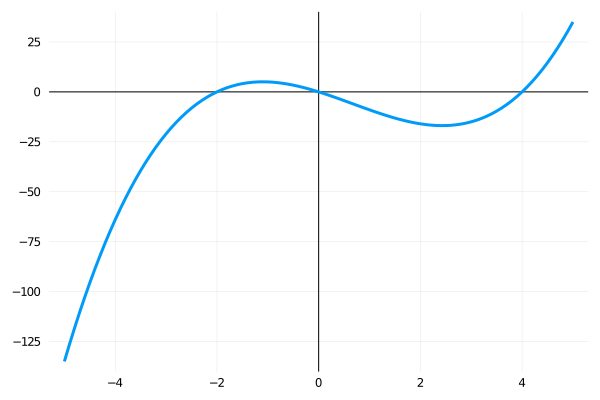

In [2515]:
f = fromroots([-2, 0, 4])
df = Polynomial([-8, -4, 3])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -5, 5, linewidth = 3, label = false)

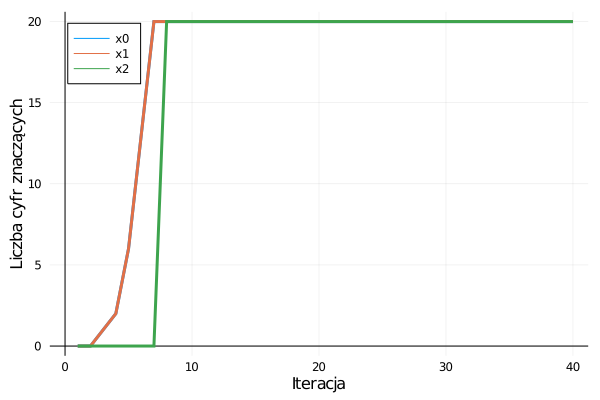

In [2516]:
TestBairstow(f, 0.1, 0.1, M, -2, 0, 4)

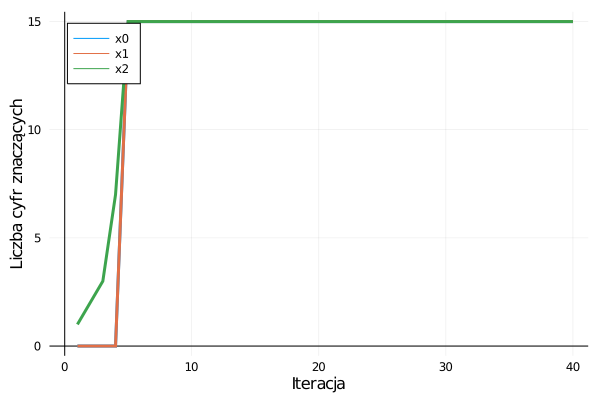

In [2517]:
TestNewton(f, x_0, ε, M, 4, -2, 0)

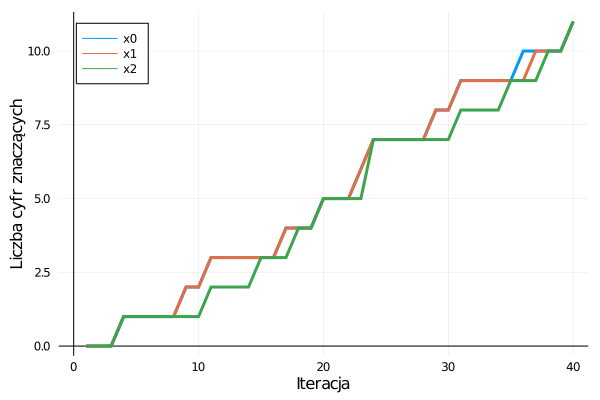

In [2518]:
TestBisection(f, 15, -10, ε, M, 4, -2, 0)

In [2519]:
TestCardano(f, 4, -2, 0)

Błąd względny x0: 0.0
Błąd względny x1: 0.0
Błąd względny x2: 0.0


### Test 2

Funkcja, która ma miejsca zerowe odległe od 0, oraz podwójny pierwiastek.

$f(x) = x^3 + 2x^2 + 3815x - 88200$

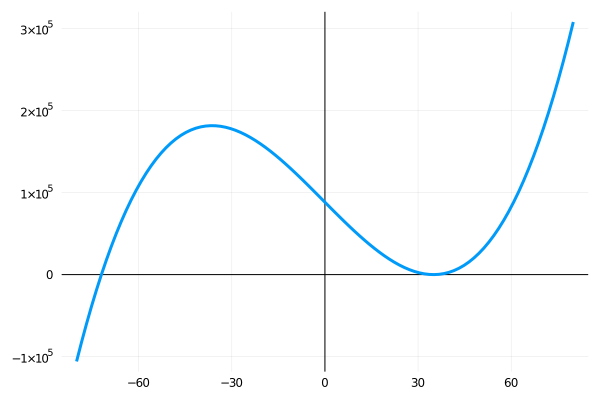

In [2520]:
f = fromroots([35, 35, -72])
df = Polynomial([-3815, 4, 3])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -80, 80, linewidth = 3, label = false)

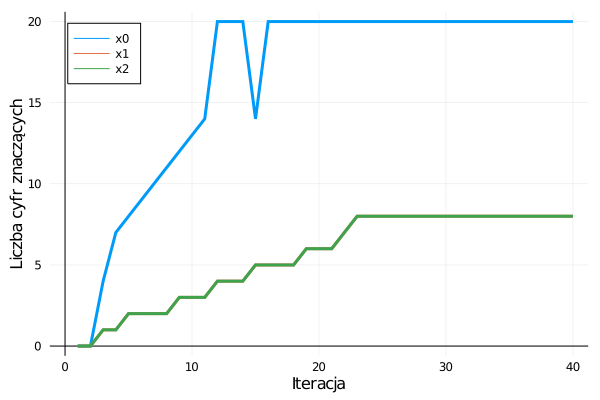

In [2521]:
TestBairstow(f, 1, 1, M, -72, 35, 35)

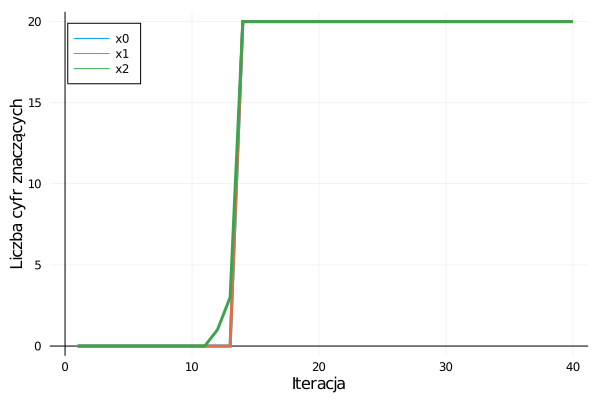

In [2522]:
TestNewton(f, x_0, ε, M, 35, -72, 35)

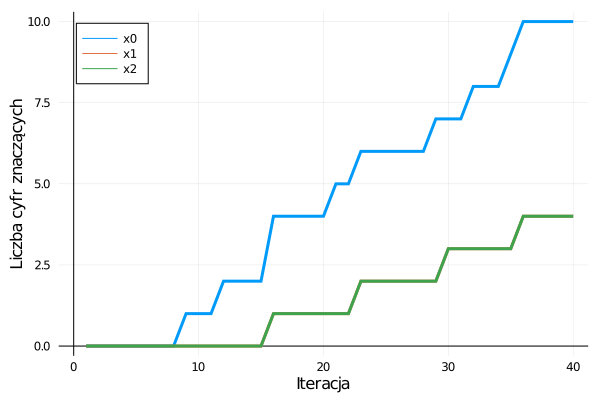

In [2523]:
TestBisection(f, -100, 100, ε, M, -72, 35, 35)

In [2524]:
TestCardano(f, -72, 35, 35)

Błąd względny x0: 0.0
Błąd względny x1: 0.0
Błąd względny x2: 0.0


### Test 3

Funkcja mająca 2 pierwiastki zespolone i jeden oddalony od 0

$f(x) = x^3 - 51x^2 + 281.25x - 506.25$

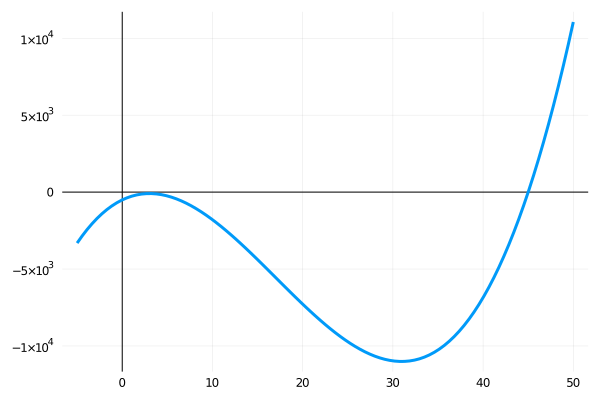

In [2525]:
f = fromroots([3 - 1.5im, 3 + 1.5im, 45])
df = Polynomial([281.25, -102, 3])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -5, 50, linewidth = 3, label = false)

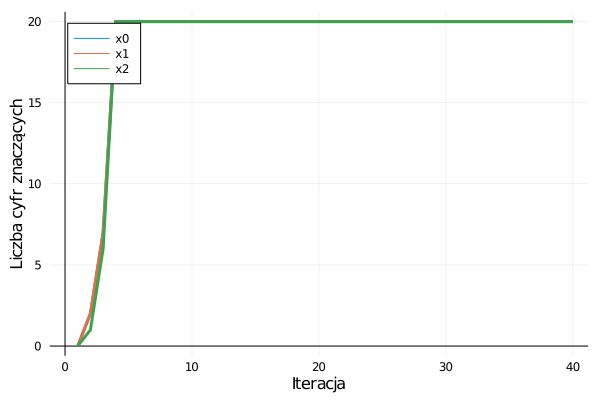

In [2526]:
TestBairstow(f, 1, 1, M, 3 + 1.5im, 3 - 1.5im, 45)

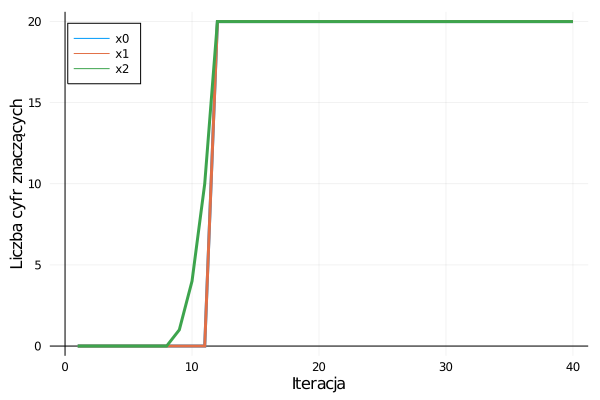

In [2527]:
TestNewton(f, x_0, ε, M, 3 + 1.5im, 45, 3 - 1.5im)

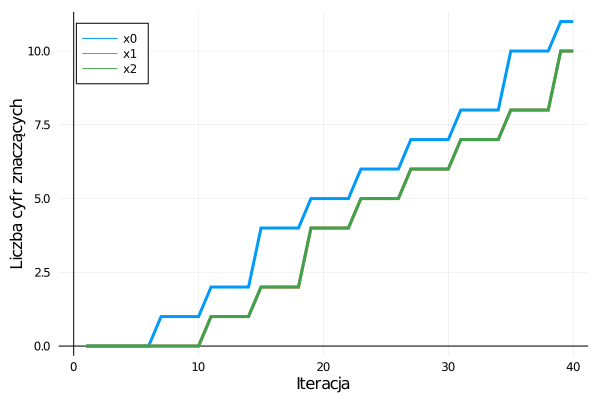

In [2528]:
TestBisection(f, -50, 100, ε, M, 45, 3 + 1.5im, 3 - 1.5im)

In [2529]:
TestCardano(f, 45, 3 + 1.5im, 3 - 1.5im)

Błąd względny x0: 0.0
Błąd względny x1: 8.881784197001252e-16
Błąd względny x2: 8.881784197001252e-16


### Test 3

Funkcja, która ma pierwiastki bardzo blisko siebie

$ f(x) = x^3 + 2.3699500000000002x^2 - 38.976263499999995 + 68.71088465$

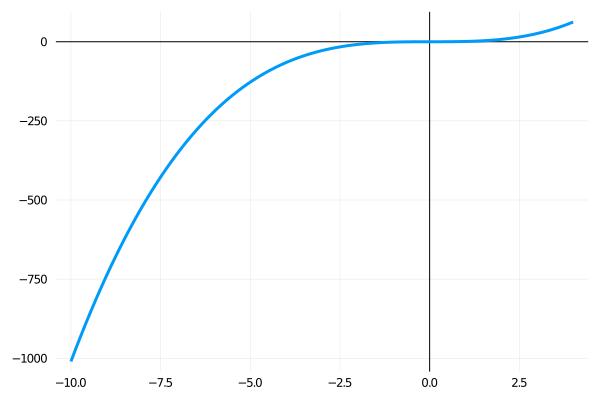

In [2542]:
f = fromroots([0, 0.1, 0])
df = Polynomial([-38.976263499999995, 4.7399000000000004, 3])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -10, 4, linewidth = 3, label = false)

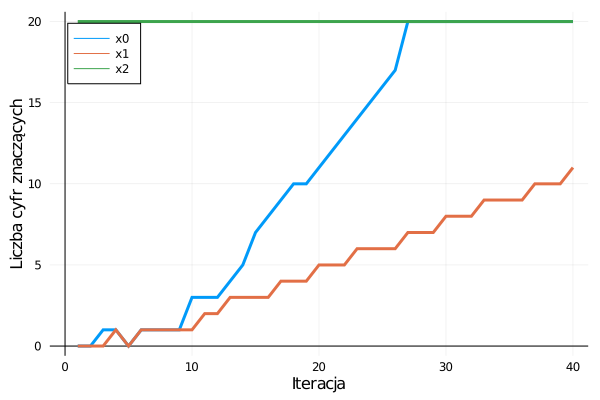

In [2543]:
TestBairstow(f, 1, 1, M, 0.1, 0, 0)

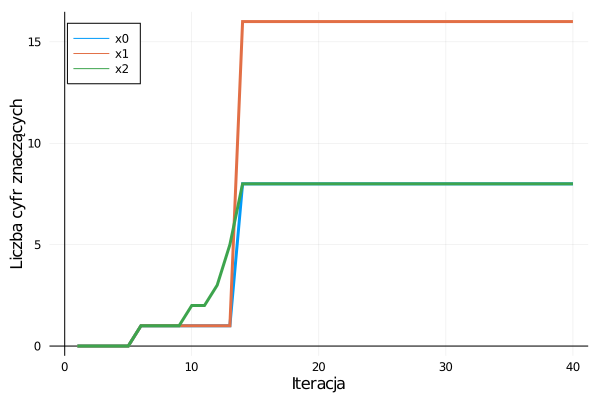

In [2546]:
TestNewton(f, x_0, ε, M, 0, 0.1, 0)

In [2547]:
TestCardano(f, 0.1, 0, 0)

Błąd względny x0: 0.0
Błąd względny x1: 2.3629366184170625e-10
Błąd względny x2: 2.3629364796391844e-10


### Test 4

Funkcja, o wybranych współczynnikach tak, aby oblczenia były 'niebezpieczne' numerycznie

$f(x) = x^3 + 1.0000001038583122x^2 + 0.33333364701740337x + 1.6666667812898837$

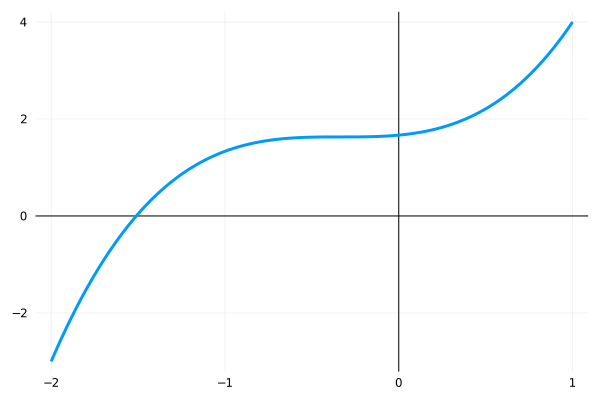

In [2548]:
df = Polynomial([0.33333364701740337, 2.0000002077166243, 3])
f = fromroots([-1.5101160823533357 + 0.0im, 
                0.2550579892475119 - 1.0191238453343947im, 
                0.2550579892475119 + 1.0191238453343947im])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -2, 1, linewidth = 3, label = false)

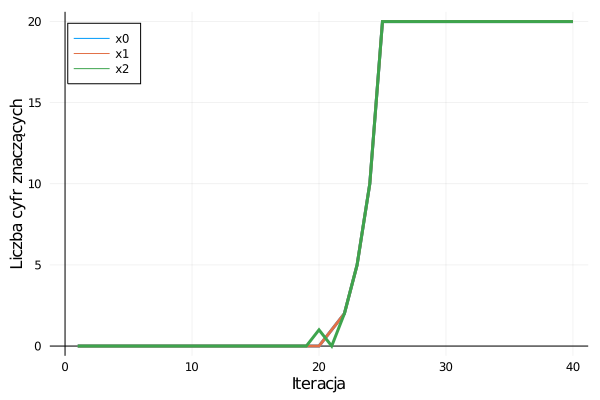

In [2549]:
TestBairstow(f, 1, 1, M,
                0.2550579892475119 + 1.0191238453343947im, 
                0.2550579892475119 - 1.0191238453343947im,
                -1.5101160823533357 + 0.0im)

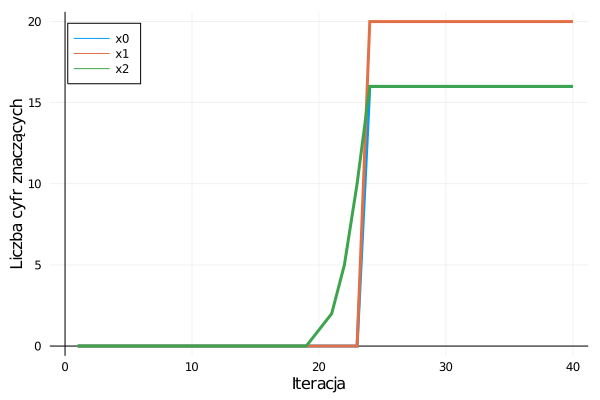

In [2550]:
TestNewton(f, x_0, ε, M, 
            0.2550579892475119 + 1.0191238453343947im,
            -1.5101160823533357 + 0.0im,
            0.2550579892475119 - 1.0191238453343947im)

In [2551]:
TestCardano(f, -1.510115978491691 + 0.0im, 0.2550579892475119 + 1.0191238453343947im
, 0.2550579892475119 - 1.0191238453343947im)

Błąd względny x0: 1.731027414741959e-7
Błąd względny x1: 6.924109678897218e-8
Błąd względny x2: 6.924109678897218e-8


### Test 5



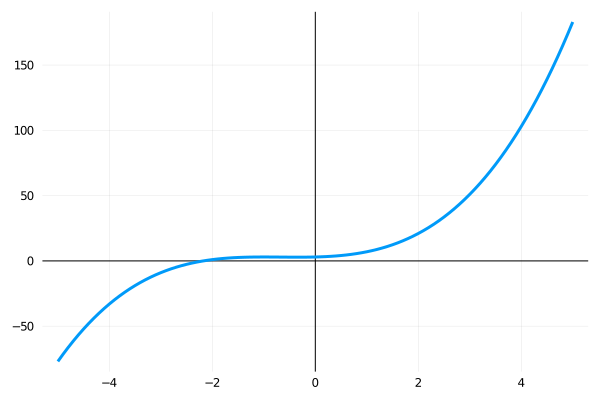

In [2552]:
df = Polynomial([3, 4, 3])
f = Polynomial([3, 1, 2, 1])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -5, 5, linewidth = 3, label = false)

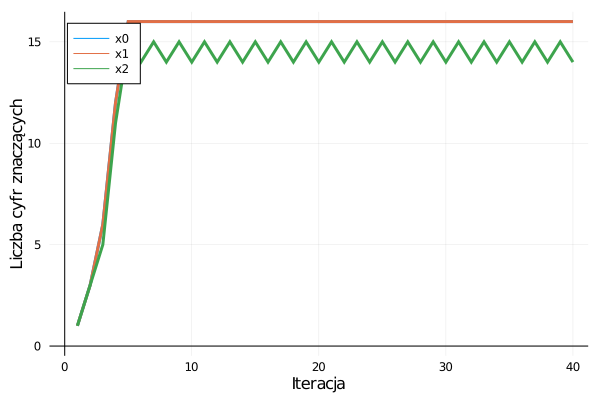

In [2553]:
TestBairstow(f, 0.1, 0.1, M, 0.08727970514648989 + 1.1713121110008786im, 
                        0.08727970514648989 - 1.1713121110008786im, 
                        -2.174559410292984 + 0.0im)

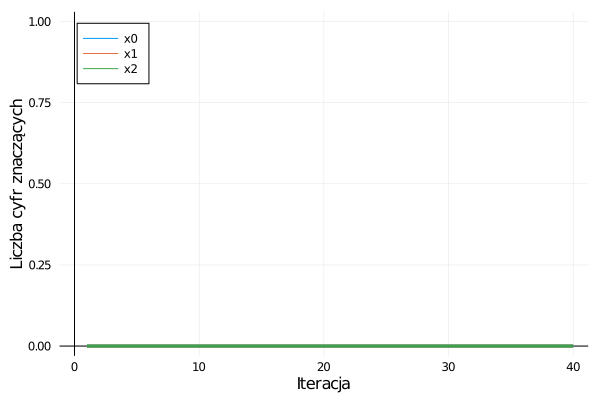

In [2554]:
TestNewton(f, x_0, ε, M, -2.174559410292984 + 0.0im,
                        0.08727970514648989 - 1.1713121110008786im,
                        0.08727970514648989 + 1.1713121110008786im)

In [2541]:
TestCardano(f, -2.174559410292984 + 0.0im,
            0.08727970514648989 + 1.1713121110008786im,
            0.08727970514648989 - 1.1713121110008786im)

Błąd względny x0: 1.3766765505351941e-14
Błąd względny x1: 9.90189642062563e-15
Błąd względny x2: 9.90189642062563e-15
